In [41]:
#!/usr/bin/python3
# coding: utf-8
# prefectures

In [42]:
import codecs
from datetime import datetime as dt
from datetime import timedelta as td
import matplotlib
import sys
if "ipy" not in sys.argv[0]:
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.neighbors import LocalOutlierFactor
from japanmap import picture
import numpy as np
import os
import pandas as pd
from PIL import Image
from cov19utils import create_basic_plot_figure, \
    show_and_clear, moving_average, \
    blank2zero, csv2array, \
    get_twitter, tweet_with_image, \
    get_gpr_predict, FONT_NAME, DT_OFFSET, \
    download_if_needed, json2nparr, code2int, age2int

In [43]:
populations = {}
all_population = 0
with codecs.open("population.txt", encoding='utf-8') as f:
    l = f.readline()
    while l:
        elems = l.split(',')
        populations[elems[3]] = dict(
            region = int(elems[0]),
            code   = int(elems[1]),
            ja     = elems[2],
            en     = elems[3],
            total = int(elems[4])
        )
        all_population += int(elems[4])
        l = f.readline().replace("\r\n", "").rstrip()
print("All population in Japan: {}".format(all_population))

All population in Japan: 127094745


In [44]:
#print(populations)

In [45]:
# 全国情報
ogiwara_uri = "https://raw.githubusercontent.com/kaz-ogiwara/covid19/master/data/"
pref_file = "prefectures.csv"
download_if_needed(ogiwara_uri, pref_file)

In [46]:
offsets = dict(
    year  = 0, # 年
    month = 1, # 月
    day   = 2, # 日
    st_ja = 3, # 都道府県
    st_en = 4, # state
    posis = 5, # 陽性者数
    tests = 6, # 検査数
    hospi = 7, # hospitalized
    serio = 8, # serious
    disch = 9, # discharged
    death =10, # deaths
    ern   =11, # Effective Reproduction Number
)

In [47]:
dt_start = dt.strptime("2020/2/8", "%Y/%m/%d") # 統計開始日
dt_now   = dt.now() # 現在日時
dt_delta = (dt_now - dt_start).days # 差分
n_states = 47 # 都道府県数
erns = [] # 実効再生産数
poss = [] # 陽性者数
test = [] # 検査数
for i in np.arange(dt_delta):
    erns.append(np.zeros(n_states+1).tolist())
    poss.append(np.zeros(n_states+1).tolist())
    test.append(np.zeros(n_states+1).tolist())
    test[i][0] = poss[i][0] = erns[i][0] = i

In [48]:
with codecs.open("prefectures.csv", encoding='utf-8') as f:
    l = f.readline()
    cnt = 0
    while l:
        l = f.readline().replace("\r\n", "").rstrip()
        elems = l.split(',')
        if len(elems) < 2:
            continue
        dt_idx  = (dt(int(elems[0]), int(elems[1]), int(elems[2])) - dt_start).days
        st_name = elems[offsets['st_en']]
        st_idx  = populations[st_name]['code']
        erns[dt_idx][st_idx] = blank2zero(elems[offsets['ern']])
        poss[dt_idx][st_idx] = blank2zero(elems[offsets['posis']])
        tested = blank2zero(elems[offsets['tests']])
        if tested > 0:
            test[dt_idx][st_idx] = tested
        cnt += 1
print("Load {} lines.".format(cnt))

Load 10007 lines.


In [49]:
erns = np.array(erns)
poss = np.array(poss)
test = np.array(test)

In [50]:
def get_os_idx_of_arr(arr, delta_days):
    os_idx = -1
    for i in np.arange(delta_days):
        if np.sum(arr[-i -1, 1:])  > 0:
            os_idx = -i -1
            print("Data offset index: {}".format(os_idx))
            break
    return os_idx

def dump_val_in_arr(arr, prefix, dec_num=1):
    print("{}: ".format(prefix), end="")
    for k, v in populations.items():
        strfmt = "{}={:." + str(dec_num) + "f} "
        print(strfmt.format(v['ja'], np.round(arr[v['code']], dec_num)), end="")
    print("")

In [51]:
os_idx = get_os_idx_of_arr(erns, dt_delta)
latest_erns = erns[os_idx] # 最新の実効再生産数
dump_val_in_arr(latest_erns, "最新の実効再生産数")

Data offset index: -1
最新の実効再生産数: 北海道=1.2 青森=1.0 岩手=0.0 宮城=1.4 秋田=0.0 山形=0.0 福島=1.0 茨城=1.2 栃木=0.6 群馬=1.6 埼玉=1.2 千葉=1.2 東京=0.9 神奈川=0.9 新潟=0.3 山梨=1.4 長野=2.4 岐阜=0.3 静岡=1.4 愛知=0.7 三重=1.2 富山=0.6 石川=0.2 福井=0.0 滋賀=0.4 京都=1.1 大阪=0.9 兵庫=1.2 奈良=1.2 和歌山=0.0 鳥取=0.0 島根=0.0 岡山=0.6 広島=0.7 山口=0.7 徳島=1.0 香川=0.0 愛媛=0.0 高知=0.0 福岡=1.1 佐賀=2.2 長崎=0.0 熊本=9.3 大分=0.0 宮崎=0.0 鹿児島=0.7 沖縄=1.4 


In [52]:
os_idx = get_os_idx_of_arr(poss, dt_delta)
latest_poss = poss[os_idx] # 最新の感染者数
dump_val_in_arr(latest_poss, "最新の感染者数", 0)

Data offset index: -1
最新の感染者数: 北海道=2229 青森=37 岩手=24 宮城=441 秋田=58 山形=78 福島=279 茨城=693 栃木=443 群馬=735 埼玉=4879 千葉=4154 東京=26869 神奈川=7266 新潟=171 山梨=196 長野=316 岐阜=631 静岡=564 愛知=5463 三重=532 富山=422 石川=778 福井=247 滋賀=508 京都=1796 大阪=10950 兵庫=2822 奈良=583 和歌山=242 鳥取=36 島根=140 岡山=161 広島=612 山口=206 徳島=149 香川=93 愛媛=115 高知=138 福岡=5061 佐賀=248 長崎=238 熊本=642 大分=158 宮崎=344 鹿児島=440 沖縄=2656 


In [53]:
def calc_last1w2w_dif(arr, name):
    idx = get_os_idx_of_arr(arr, dt_delta)
    latest_arr = arr[idx] # 最新
    last1w_arr = arr[idx -  7] # 1週間前
    last2w_arr = arr[idx - 14] # 2週間前
    diff1w_arr = latest_arr - last1w_arr # 最新と1週間前の差分
    diff2w_arr = latest_arr - last2w_arr # 最新と2週間前の差分
    dump_val_in_arr(diff1w_arr, "1週間{}".format(name), 0)
    dump_val_in_arr(diff2w_arr, "2週間{}".format(name), 0)
    return diff1w_arr, diff2w_arr

In [54]:
diff1w_poss, diff2w_poss = calc_last1w2w_dif(poss, "陽性者数")

Data offset index: -1
1週間陽性者数: 北海道=138 青森=1 岩手=1 宮城=42 秋田=5 山形=0 福島=26 茨城=36 栃木=12 群馬=34 埼玉=227 千葉=258 東京=1131 神奈川=368 新潟=1 山梨=10 長野=10 岐阜=5 静岡=26 愛知=126 三重=29 富山=4 石川=2 福井=3 滋賀=6 京都=49 大阪=357 兵庫=118 奈良=14 和歌山=0 鳥取=0 島根=0 岡山=4 広島=49 山口=4 徳島=1 香川=0 愛媛=1 高知=0 福岡=29 佐賀=3 長崎=2 熊本=68 大分=0 宮崎=0 鹿児島=25 沖縄=170 
2週間陽性者数: 北海道=245 青森=2 岩手=1 宮城=69 秋田=5 山形=0 福島=51 茨城=63 栃木=35 群馬=51 埼玉=405 千葉=465 東京=2416 神奈川=815 新潟=6 山梨=16 長野=13 岐阜=28 静岡=42 愛知=332 三重=52 富山=12 石川=17 福井=3 滋賀=27 京都=94 大阪=745 兵庫=207 奈良=25 和歌山=4 鳥取=0 島根=3 岡山=13 広島=125 山口=11 徳島=2 香川=0 愛媛=1 高知=1 福岡=55 佐賀=4 長崎=2 熊本=71 大分=0 宮崎=0 鹿児島=63 沖縄=280 


In [55]:
# 都道府県別 罹患率
incid1w_rate = np.zeros(n_states + 1).tolist() # 罹患率 (1週足)
incid2w_rate = np.zeros(n_states + 1).tolist() # 罹患率 (2週足)
incid_all_rate = np.zeros(n_states + 1).tolist() # 罹患率 (全期間)
for k, v in populations.items():
    i = v['code']
    incid1w_rate[i] = (diff1w_poss[i] / v['total']) * 100 # percentage
    incid2w_rate[i] = (diff2w_poss[i] / v['total']) * 100 # percentage
    incid_all_rate[i] = (latest_poss[i] / v['total']) * 100 # percentage

In [56]:
diff1w_test, diff2w_test = calc_last1w2w_dif(test, "検査数")

Data offset index: -1
1週間検査数: 北海道=3884 青森=116 岩手=241 宮城=750 秋田=156 山形=72 福島=1503 茨城=264 栃木=2283 群馬=2695 埼玉=6141 千葉=12343 東京=24236 神奈川=10296 新潟=561 山梨=242 長野=865 岐阜=972 静岡=2304 愛知=4544 三重=978 富山=711 石川=945 福井=187 滋賀=596 京都=2192 大阪=10578 兵庫=2937 奈良=1071 和歌山=189 鳥取=38 島根=108 岡山=544 広島=765 山口=464 徳島=133 香川=582 愛媛=82 高知=44 福岡=7734 佐賀=226 長崎=971 熊本=664 大分=820 宮崎=67 鹿児島=866 沖縄=3082 
2週間検査数: 北海道=7130 青森=255 岩手=493 宮城=1212 秋田=224 山形=174 福島=3154 茨城=528 栃木=4228 群馬=4623 埼玉=16660 千葉=23976 東京=56997 神奈川=19121 新潟=1264 山梨=504 長野=1625 岐阜=2434 静岡=4729 愛知=11471 三重=1638 富山=1345 石川=2056 福井=423 滋賀=1212 京都=4579 大阪=22829 兵庫=5831 奈良=2149 和歌山=390 鳥取=135 島根=555 岡山=793 広島=1854 山口=1185 徳島=247 香川=1115 愛媛=155 高知=114 福岡=92976 佐賀=525 長崎=1937 熊本=975 大分=2034 宮崎=152 鹿児島=1942 沖縄=5288 


In [57]:
# 都道府県別 陽性率
test1w_rate = np.zeros(n_states + 1).tolist() # 陽性率 (1週足)
test2w_rate = np.zeros(n_states + 1).tolist() # 陽性率 (2週足)
for k, v in populations.items():
    i = v['code']
    if diff1w_test[i] > 0:
        test1w_rate[i] = (diff1w_poss[i] / diff1w_test[i]) * 100 # percentage
    if diff2w_test[i] > 0:
        test2w_rate[i] = (diff2w_poss[i] / diff2w_test[i]) * 100 # percentage
dump_val_in_arr(test1w_rate, "1週間陽性率", 1)
dump_val_in_arr(test2w_rate, "2週間陽性率", 1)

1週間陽性率: 北海道=3.6 青森=0.9 岩手=0.4 宮城=5.6 秋田=3.2 山形=0.0 福島=1.7 茨城=13.6 栃木=0.5 群馬=1.3 埼玉=3.7 千葉=2.1 東京=4.7 神奈川=3.6 新潟=0.2 山梨=4.1 長野=1.2 岐阜=0.5 静岡=1.1 愛知=2.8 三重=3.0 富山=0.6 石川=0.2 福井=1.6 滋賀=1.0 京都=2.2 大阪=3.4 兵庫=4.0 奈良=1.3 和歌山=0.0 鳥取=0.0 島根=0.0 岡山=0.7 広島=6.4 山口=0.9 徳島=0.8 香川=0.0 愛媛=1.2 高知=0.0 福岡=0.4 佐賀=1.3 長崎=0.2 熊本=10.2 大分=0.0 宮崎=0.0 鹿児島=2.9 沖縄=5.5 
2週間陽性率: 北海道=3.4 青森=0.8 岩手=0.2 宮城=5.7 秋田=2.2 山形=0.0 福島=1.6 茨城=11.9 栃木=0.8 群馬=1.1 埼玉=2.4 千葉=1.9 東京=4.2 神奈川=4.3 新潟=0.5 山梨=3.2 長野=0.8 岐阜=1.2 静岡=0.9 愛知=2.9 三重=3.2 富山=0.9 石川=0.8 福井=0.7 滋賀=2.2 京都=2.1 大阪=3.3 兵庫=3.5 奈良=1.2 和歌山=1.0 鳥取=0.0 島根=0.5 岡山=1.6 広島=6.7 山口=0.9 徳島=0.8 香川=0.0 愛媛=0.6 高知=0.9 福岡=0.1 佐賀=0.8 長崎=0.1 熊本=7.3 大分=0.0 宮崎=0.0 鹿児島=3.2 沖縄=5.3 


In [58]:
def create_basic_scatter_figure(xlabel, ylabel):
    """ 基本散布図テンプレートを作成する """
    plt.close()
    plt.style.use("dark_background")
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(111)
    plt.xlabel(xlabel, fontname=FONT_NAME)
    plt.ylabel(ylabel, fontname=FONT_NAME)
    plt.grid(True)
    #plt.subplots_adjust(left=0.07, right=0.97, bottom=0.07, top=0.97)
    return fig, ax

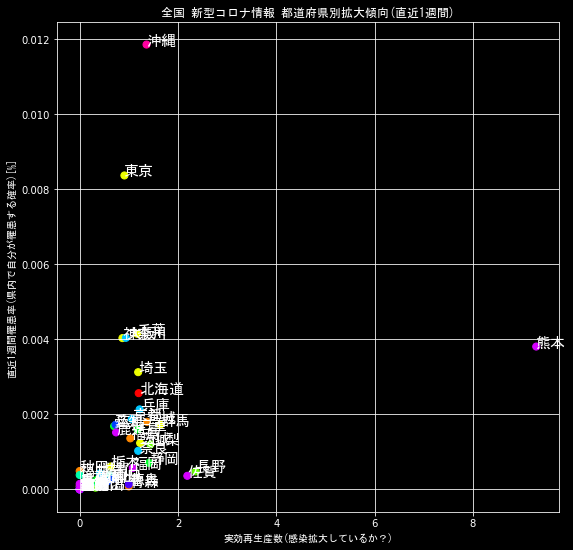

In [59]:
fig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近1週間罹患率(県内で自分が罹患する確率)[%]")
cols = [ "#ff0000" for i in range(n_states)]
texts = [ "?" for i in range(n_states)]
for k, v in populations.items():
    cols[v['code'] - 1]  = cm.hsv(v['region'] / 11)
    texts[v['code'] - 1] = v['ja']
plt.scatter(latest_erns[1:], incid1w_rate[1:], s=50, c=cols)
for i in range(n_states):
    ax.annotate(texts[i], xy=(latest_erns[1 + i], incid1w_rate[1 + i]), size=15, fontname=FONT_NAME)
tw_body_1w = '全国 新型コロナ情報 都道府県別拡大傾向(直近1週間)'
plt.title(tw_body_1w, fontname=FONT_NAME)

show_and_clear(fig, "images/ern-1w_poss.jpg")

In [60]:
def show_zoomed_ern_scatter(
    xbins, ybins, colors, xytexts, nweek, filename, title, xlabel, ylabel,
    n_neighbors=30, n_states=47):
    fig, ax = create_basic_scatter_figure(xlabel, ylabel)
    # LOF
    clf = LocalOutlierFactor(
        n_neighbors=n_neighbors, contamination='auto',
        algorithm='auto', metric='mahalanobis')
    X = np.stack([xbins[1:], ybins[1:]], 1)
    y_pred = clf.fit_predict(X)
    selected_cols = np.array(colors)[y_pred == 1]
    selected_text = np.array(xytexts)[y_pred == 1]
    # append top element
    y_pred = np.append(-1, y_pred)
    selected_xbins = xbins[y_pred == 1]
    selected_ybins = np.array(ybins)[y_pred == 1]
    plt.xlim(0, np.max(selected_xbins))
    plt.ylim(0, np.max(selected_ybins))
    plt.scatter(selected_xbins, selected_ybins, s=50, c=selected_cols)
    for i in np.arange(len(selected_xbins)):
        ax.annotate(selected_text[i], xy=(selected_xbins[i], selected_ybins[i]), size=15, fontname=FONT_NAME)
    plt.title(title, fontname=FONT_NAME)
    show_and_clear(fig, filename)

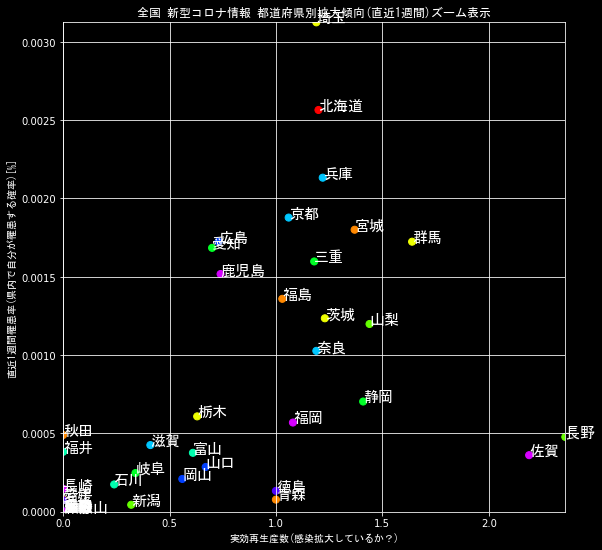

In [61]:
tw_body_1w_zoom = '全国 新型コロナ情報 都道府県別拡大傾向(直近1週間)ズーム表示'
show_zoomed_ern_scatter(
    latest_erns, incid1w_rate, cols, texts, 1, "images/ern-1w_poss-zoom.jpg",
    tw_body_1w_zoom,
    "実効再生産数(感染拡大しているか？)",
    "直近1週間罹患率(県内で自分が罹患する確率)[%]")

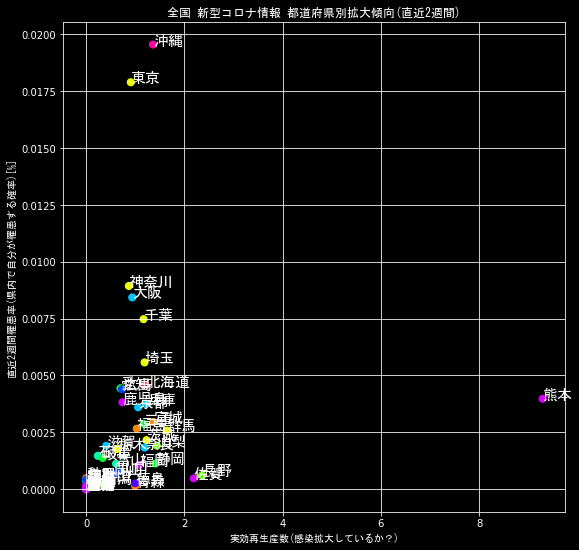

In [62]:
fig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近2週間罹患率(県内で自分が罹患する確率)[%]")
plt.scatter(latest_erns[1:], incid2w_rate[1:], s=50, c=cols)
tw_body_2w = '全国 新型コロナ情報 都道府県別拡大傾向(直近2週間)'
plt.title(tw_body_2w, fontname=FONT_NAME)
for i in range(n_states):
    ax.annotate(texts[i], xy=(latest_erns[1 + i], incid2w_rate[1 + i]), size=15, fontname=FONT_NAME)
show_and_clear(fig, "images/ern-2w_poss.jpg")

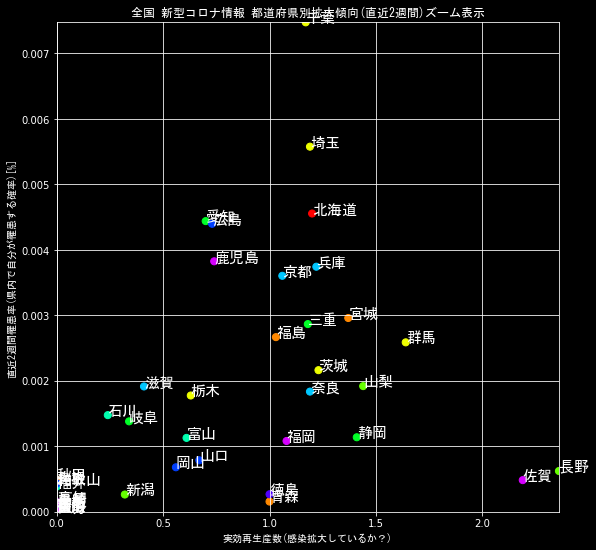

In [63]:
tw_body_2w_zoom = '全国 新型コロナ情報 都道府県別拡大傾向(直近2週間)ズーム表示'
show_zoomed_ern_scatter(
    latest_erns, incid2w_rate, cols, texts, 2, "images/ern-2w_poss-zoom.jpg",
    tw_body_2w_zoom,
    "実効再生産数(感染拡大しているか？)",
    "直近2週間罹患率(県内で自分が罹患する確率)[%]")

In [64]:
def mak_japan_heatmap(filename, title, npa1d):
    plt.close()
    plt.style.use("dark_background")
    plt.subplots_adjust(left=0.07, right=0.99, bottom=0.07, top=0.95)
    plt.title(title, fontname=FONT_NAME)
    plt.rcParams['figure.figsize'] = 6, 6
    cmap = plt.get_cmap("Reds")
    norm = plt.Normalize(vmin=np.min(npa1d[1:]), vmax=np.max(npa1d[1:]))
    fcol = lambda x: '#' + bytes(cmap(norm(x), bytes=True)[:3]).hex()
    plt.colorbar(cm.ScalarMappable(norm, cmap))
    map_cols = {}
    for k, v in populations.items():
        map_cols[v['ja']] = fcol(npa1d[v['code']])
    pict = picture(map_cols)
    plt.imshow(pict)
    plt.savefig(filename)

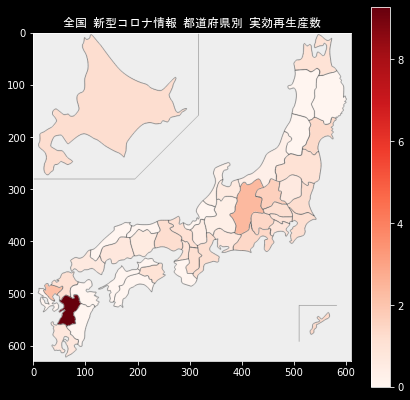

In [65]:
tw_body_map_erns = "全国 新型コロナ情報 都道府県別 実効再生産数"
mak_japan_heatmap('images/japan-erns.jpg', tw_body_map_erns, latest_erns)

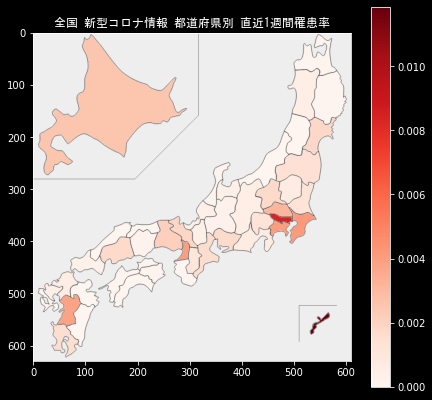

In [66]:
tw_body_map_1w = "全国 新型コロナ情報 都道府県別 直近1週間罹患率"
mak_japan_heatmap('images/japan-1w.jpg', tw_body_map_1w, incid1w_rate)

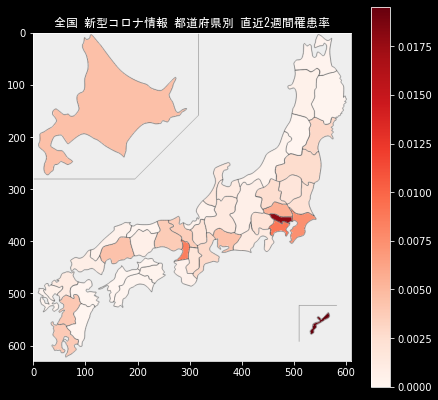

In [67]:
tw_body_map_2w = "全国 新型コロナ情報 都道府県別 直近2週間罹患率"
mak_japan_heatmap('images/japan-2w.jpg', tw_body_map_2w, incid2w_rate)

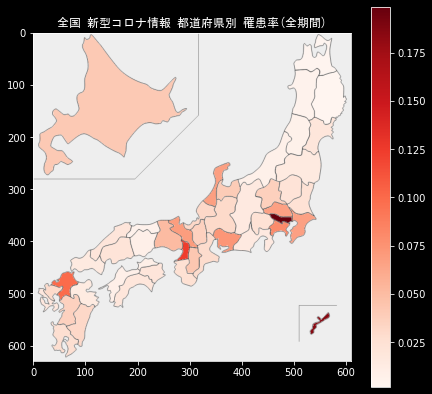

In [68]:
tw_body_map_all = "全国 新型コロナ情報 都道府県別 罹患率(全期間)"
mak_japan_heatmap('images/japan-all.jpg', tw_body_map_all, incid_all_rate)

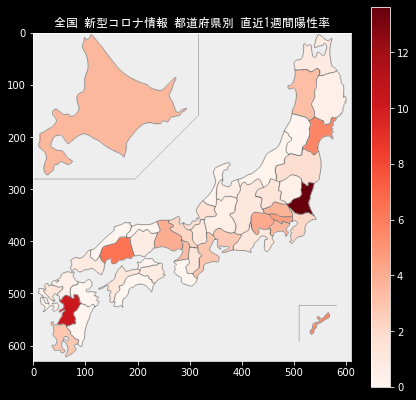

In [69]:
tw_body_map_rate1w = "全国 新型コロナ情報 都道府県別 直近1週間陽性率"
mak_japan_heatmap('images/japan-rate1w.jpg', tw_body_map_rate1w, test1w_rate)

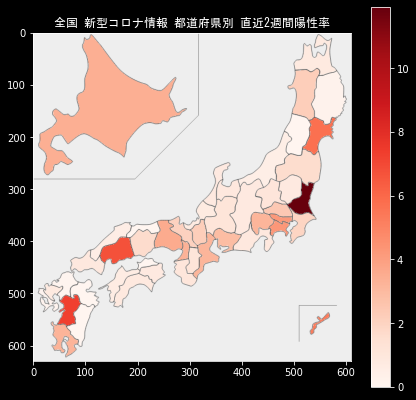

In [70]:
tw_body_map_rate2w = "全国 新型コロナ情報 都道府県別 直近2週間陽性率"
mak_japan_heatmap('images/japan-rate2w.jpg', tw_body_map_rate2w, test2w_rate)

In [71]:
tw = get_twitter()
today_str = dt.now().isoformat()[:19].replace('T', ' ')
tw_body_postfix = " (東洋経済 " + today_str + " 現在)"
#tweet_with_image(tw, "images/ern-1w_poss.jpg", tw_body_1w + tw_body_postfix)
#tweet_with_image(tw, "images/ern-1w_poss-zoom.jpg", tw_body_1w_zoom + tw_body_postfix)
tweet_with_image(tw, "images/ern-2w_poss.jpg", tw_body_2w + tw_body_postfix)
tweet_with_image(tw, "images/ern-2w_poss-zoom.jpg", tw_body_2w_zoom + tw_body_postfix)

In [72]:
tweet_with_image(tw, 'images/japan-erns.jpg', tw_body_map_erns + tw_body_postfix)
#tweet_with_image(tw, 'images/japan-1w.jpg', tw_body_map_1w + tw_body_postfix)
tweet_with_image(tw, 'images/japan-2w.jpg', tw_body_map_2w + tw_body_postfix)
tweet_with_image(tw, 'images/japan-all.jpg', tw_body_map_all + tw_body_postfix)

In [73]:
tweet_with_image(tw, 'images/japan-rate1w.jpg', tw_body_map_rate1w + tw_body_postfix)
tweet_with_image(tw, 'images/japan-rate2w.jpg', tw_body_map_rate2w + tw_body_postfix)